# Notebook 2: Rating Curve Development

In [1]:
import os
import math
import pandas as pd
import numpy as np
from scipy import stats as st

import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'pandas'

## Introduction

### Pressure Transducer

It isn't practical to accurately measure surface runoff directly on a *continuous* basis.  In practice, it is much easier and more reliable to install an instrument at a fixed location in the river to measure water pressure, which recall is a linear function of the depth of water, to collect these measurements at a frequency of minutes or hours, and then to establish a mathematical relation between water depth and volumetric flow.

![Pressure Transducer](img/transducer.png)

### Hydrometric Station

A hydrometric station is often simply a pressure transducer (shown above) connected to a computer (a datalogger) to store measurements in memory.  We then need a way to map these recorded water level measurements to **volumetric flow** ($\frac{m^3}{s}$).  The pressure transducer is often fastened within a protective pipe (as shown in the image below) to protect it from debris moving during high flows.  

Benchmarks are used to validate both the position of the pressure transducer and the calibration of the sensor.  **Benchmark survey is critical to the validation of your measured flow series!**  

>**Note**: Water level or depth is often referred to as 'stage'.

![Hydrometric Station](img/station.png)

In Notebook 1, we processed a single discharge measurement taken using the salt dilution method.  Typically we want to collect discharge measurements to describe as much of the expected range of natural flow conditions as possible, from very low flows in the dry season, to the highest flows we can (safely) measure.

Go through this notebook and follow along with the development of the stage-discharge rating curve. At the end, there is an open ended question that requires you to reflect on the content of the notebook. 

>**Note**: [A folder of references is provided in the repository](https://github.com/dankovacek/Engineering_Hydrology_Notebooks/tree/main/content/notebooks/Notebook_2/References) containing governing standards for hydrometric data collection, as well as a discussion paper on uncertainty in hydrometric data collection.

## Stage-Discharge (Rating Curve) Development

The purpose of establishing continuous collection of stage data, and collecting many discharge (flow) measurements is to establish (and validate) a relationship between the water level and the volumetric flow over a wide range of conditions:

![Stage-Discharge Relationship (source: Hamilton & Moore (2012))](img/rating_curve_ex.png)

Each point in the above plot represents an 'instantaneous' or 'point in time' discharge measurement, and the water level (stage) at the time the discharge measurement was taken.

In this exercise, we will develop a stage-discharge relationship from a collection of discharge measurements and the corresponding stage record. Once a valid stage-discharge relationship has been established, it can be used to translate the time series of **stage** to a time series of **discharge**.

## Import the Data

In [4]:
os.listdir('../../notebook_data/notebook_2_data')

['RC_Data.csv',
 'WL_data.csv',
 'Regional_data.csv',
 'SD_cal.csv',
 'SD_data.csv']

In [5]:
# import the stage data
stage_df = pd.read_csv('../../notebook_data/notebook_2_data/WL_data.csv', parse_dates=['Date'])

In [6]:
# take a quick look at the file contents
stage_df

,Date,Water level (daily av.) (m)
0,2009-01-01,0.240
1,2009-01-02,0.236
2,2009-01-03,0.234
3,2009-01-04,0.233
4,2009-01-05,0.231
...,...,...
725,2010-12-27,0.288
726,2010-12-28,0.287
727,2010-12-29,0.265
728,2010-12-30,0.248


In [7]:
# looking at the data preview above, the water level (stage) label is quite long
# lets store it in a more convenient variable
stage_label = 'Water level (daily av.) (m)'

stage_df = stage_df[['Date', stage_label]].copy()


Open the rating curve data file (the set of discrete flow measurements).

In [28]:
# import the table of discrete discharge measurements
rc_df = pd.read_csv('../../notebook_data/notebook_2_data/RC_Data.csv', parse_dates=['Date'])

In [29]:
# take a look at the discharge measurements
rc_df.head(15)

,Date,Flow (m3/s),Water level (m)
0,2009-01-02,1.565,0.236
1,2009-01-07,1.530,0.267
2,2009-03-20,0.967,0.224
3,2009-09-12,5.133,0.707
4,2009-11-10,3.402,0.468
5,2009-11-18,4.474,0.589
6,2010-03-24,1.297,0.296
7,2010-03-25,1.823,0.300
8,2010-08-25,4.682,0.632


In [30]:
print(f'There are a total of {len(rc_df)} discharge measurements.')

There are a total of 9 discharge measurements.


## Plot the Data

### Plot Measured Discharge and corresponding stage (water level)

From previous site visits, we have collected a total of 9 discharge measurements as can be seen in the `rc_df` dataframe above.  During each measurement, we manually measure the water level to validate the data being recorded continuously by our pressure transducer and datalogger (hydrometric station).  We validate the pressure transducer reading because instrument calibration is not perfect, and can change over time for a number of reasons.  

It is important to measure stage by some independent means before and after a discharge measurement in order to to assess the quality of the stage-discharge relationship and any analysis derived from it.  Validating the hydrometric station stage concurrent to a discharge measurement is typically done manually, such as by a benchmark survey.


<AxesSubplot:xlabel='Flow (m3/s)'>

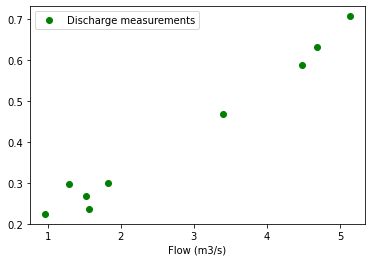

In [31]:
# plot the discharge measurements on the x-axis, and the corresponding stage on the y axis
q_measured = 'Flow (m3/s)'
wl_measured = 'Water level (m)'
rc_df.plot(q_measured, wl_measured, 
           marker='o', color='g',
           linestyle='',
           label='Discharge measurements')

### Add the new discharge measurement

In Notebook 1, we processed a discharge measurement using salt dilution.  Let's update our rating curve with this latest data point.

### Find the stage on the measurement date

Instead of manually looking up what the water level was on a particular date, we can use an indexing method to directly return the value at the time of interest./

In [32]:
# get the measurement_date from the salt dilution data files
msmt_date = '2010-09-26'
# conver the date from a string to a "datetime" type
msmt_date = pd.to_datetime(msmt_date)
 
# here, we are indexing the stage dataframe to return 
# just the row corresponding to the date we're interested in
msmt_date_data = stage_df[stage_df['Date'] == msmt_date]

# now just extract the stage
# and round to 3 decimals
msmt_stage = msmt_date_data[stage_label].round(3)

# Note that the msmt_stage variable is still a dataframe
print(msmt_stage)
print('------')
print('')

# To get just the value, use the `.values` attribute 
# which returns an array
msmt_stage = msmt_stage.values[0]
print(f'The stage on {msmt_date} was {msmt_stage} m.')

633    1.313
Name: Water level (daily av.) (m), dtype: float64
------

The stage on 2010-09-26 00:00:00 was 1.313 m.


### Add the latest data to the discharge table.

In Notebook 1, we calculated discharge using the salt dilution method.  Add this measurement to `rc_df` and see how it compares to the rest of the measurements.

>**Note**: If you make a mistake in adding new discharge measurements, you should re-run the notebook from the cell where `rc_df` is first declared.  Otherwise the erroneous measurement will stay in your table!  Copy the line `rc_df.loc[len(rc_df)] = [pd.to_datetime(msmt_date), Q_calculated, msmt_stage]` and replace the `Q_calculated` and `msmt_stage` variables with random numbers a few times to convince yourself of the outcome.  

In [33]:
rc_df

,Date,Flow (m3/s),Water level (m)
0,2009-01-02,1.565,0.236
1,2009-01-07,1.530,0.267
2,2009-03-20,0.967,0.224
3,2009-09-12,5.133,0.707
4,2009-11-10,3.402,0.468
5,2009-11-18,4.474,0.589
6,2010-03-24,1.297,0.296
7,2010-03-25,1.823,0.300
8,2010-08-25,4.682,0.632


In [34]:


Q_calculated = 12 # enter the value you calculated from Notebook 1
concurrent_stage = msmt_stage # we determined msmst_stage in the previous cell

# Add the newly measured point to the rating curve (discharge data) dataframe
next_idx = len(rc_df)
# the .loc[] function is a way to index row(s) & column(s) of a table.
# here we want to add a new complete row, so we use `:` to say "all columns"
rc_df.loc[len(rc_df), :] = [msmt_date, Q_calculated, msmt_stage]

# print out the updated dataframe and see the new point added
rc_df

,Date,Flow (m3/s),Water level (m)
0,2009-01-02,1.565,0.236
1,2009-01-07,1.530,0.267
2,2009-03-20,0.967,0.224
3,2009-09-12,5.133,0.707
4,2009-11-10,3.402,0.468
5,2009-11-18,4.474,0.589
6,2010-03-24,1.297,0.296
7,2010-03-25,1.823,0.300
8,2010-08-25,4.682,0.632
9,2010-09-26,12.000,1.313


### Plot a Curve Representing the Standard Stage-Discharge Relationship

The standard stage-discharge relationship takes the form $Q = C(h-h_0)^b$ where:

* Q = flow $[\frac {m^3}{s}]$
* C = rating coefficient $[-]$
* $h_0$ = elevation offset $[m]$ corresponding to the point of zero flow
* b = hydraulic control shape coefficient $[-]$

The rating exponent (b) is related to some extent to the cross sectional shape of the hydraulic control.  Values for the rating exponent suggested by Environment Canada (2012) are as follows:

| Shape | Value of exponent (b) |
|---|---|
| Rectangular | 1.3 to 1.8 |
| Parabolic | 1.7 to 2.3 |
| Triangular | 2.5 to 3 |


In [35]:
# definition of rating curve: calculate Q from h, given the parameters.
def calc_q(C, h, h0, b):
    """
    Standard form of the rating curve equation.
        Q = flow [m^3/s]
        C = rating coefficient [-]
        h0 = elevation offset [m] - corresponds to point of zero flow
        b = hydraulic control shape coefficient [-]
    Return volumetric flow [m^3/s]
    """
    return C*(h-h0)**b

Below are rating curve parameters (`h0`, `b`, `C`) that are **a simple visual fit** to the discharge data.  

Try changing the values of `h0`, `b`, and `C` to see the effect on how the curve fits the measured discharge data.

In [36]:
h0 = -0.1   # offset parameter
b = 1.8      # exponent (shape) parameter
C = 8.0      # coefficient parameter

# here, set a range of stage values over which
# we will calculate discharge based on our rating curve parameters
stage_range = np.linspace(0.001, 1.5, 100)

# here we calculate flow (q) for every value of stage
# we defined in stage_range above
manual_fit_q = [calc_q(C, h, h0, b) for h in stage_range]

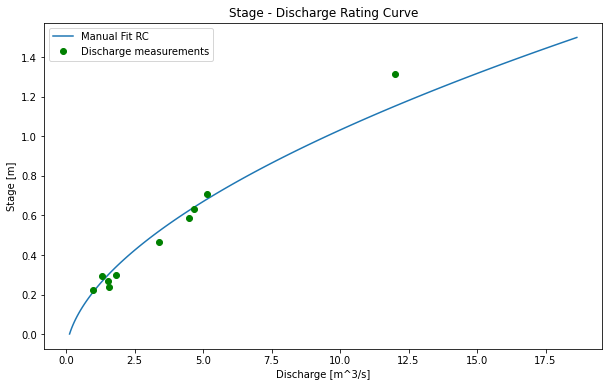

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(manual_fit_q, stage_range, label='Manual Fit RC')
ax.plot(rc_df[q_measured].to_numpy(), rc_df[wl_measured].to_numpy(), 
           marker='o', color='g',
           linestyle='',
           label='Discharge measurements')
ax.set_title('Stage - Discharge Rating Curve')
ax.set_xlabel('Discharge [m^3/s]')
ax.set_ylabel('Stage [m]')
ax.legend()
plt.show()

## Curve Fitting Method

Above, we plotted the stage-discharge curve using made up parameters for C, h0, and b.  We can use a "guess-and-check" method to change the parameters until they have a 'good' visual fit, but let's be more efficient and systematic and use a "best fit" method.

Because our equation is not linear (normally $b \neq 1$), we can't use the linear best fit function shown in Tutorial 1.  Or can we?

Recall the rating curve equation from above is: $Q = C(H-h_0)^b$.  

If we transform the data to log space, we get the following: $log(Q) = log(C) + b\cdot log(h-h_0)$

We can then rearrange the terms to match the linear form: $y = slope \cdot x + intercept$.

Recall the x and y axis parameters are discharge (Q) and water level (h), respectively, so the linear form of the equation is then: 

$$log(h-h_0) = slope \cdot log(Q) + intercept$$

Using this linear form of the equation, we can use the ordinary least squares (OLS) method to find the slope and intercept corresponding to the best fit line (in log-log space).  The last step is to transform the values back to linear space.

Note that $h_0$ cannot be fitted this way, and has to be set manually. In this case we start by assuming $h_0=0$.

In [38]:
# Find the best-fit line in log-log space
# set our stage offset to zero
h0 = 0
# take the logarithm of the measured streamflows and the stage
q_log = np.log(rc_df['Flow (m3/s)'] - h0)
stage_log = np.log(rc_df['Water level (m)'])

# find the slope and intercept parameters describing the linear best fit using ordinary least squares (OLS)
log_slope, log_intercept, log_rval, log_pval, log_stderr = st.linregress(q_log, stage_log)

The linearized form of the best fit equation was shown in the last step: $log(h-h_0) = slope \cdot log(Q) + intercept$.

The `st.linregress` function solved the ordinary least squares best fit and yielded the `slope` and `intercept` of the best fit line, so we have two unknowns.  When we plotted the general stage-discharge curve above, we set a variable `stage_range` to evaluate the range of water level over which we're interested in knowing the corresponding flow.  The remaining unknown is then the `log(Q)` term, but we want a function that will give us the discharge (`Q`) in linear space.  

### Solve for Q

The last step is to rearrange the log form of the equation we derived previously ($log(h-h_0) = slope \cdot log(Q) + intercept$) in order to solve for flow (`Q`).  

In [39]:
# calculate the discharge based on the best fit
# parameters found by ordinary least squares above
def ols_rc_q(slope, intercept, h, h0):
    """
    Calculate flow (Q) from the linear best fit parameters.
        -slope: the `log_slope` calculated above (constant)
        -intercept: `log_intercept` calculated above (constant)
        -h0 is the same PZF offset used above (constant)
        -h is the independent variable
    Returns Q, the discharge in m^3/s.
    """
    if slope == 0:
        return 0
    try:
        return np.exp((np.log(h - h0) - intercept) / slope)
    except ValueError: 
        return None

In [40]:
# put best fit results into a dataframe for plotting
# use 0 as the PZF (point of zero flow) (the h0 parameter)
bf_df = pd.DataFrame()
bf_df['stage'] = stage_range

# now as before, apply the `ols_rc_q` function to create the stage-discharge
# curve based on the best-fit equation
bf_df['best_fit_q'] = [ols_rc_q(log_slope, log_intercept, h, 0) for h in stage_range]
bf_df.sort_values(by='stage', inplace=True)

# now add the manual fit we developed above -- this way we can compare the two curves side-by-side
bf_df['manual_fit_q'] = manual_fit_q

### Plot the best fit curve


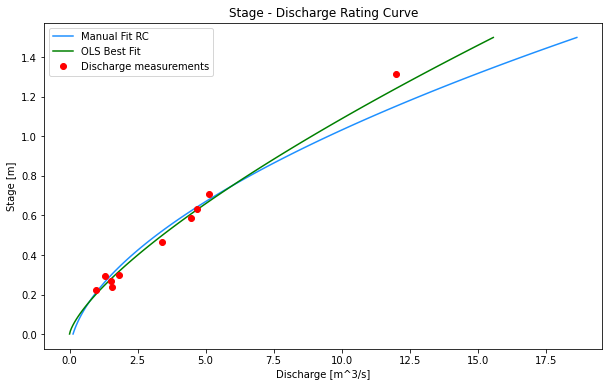

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(manual_fit_q, stage_range, color='dodgerblue', label='Manual Fit RC')
ax.plot(bf_df['best_fit_q'], bf_df['stage'],
        color='green', label="OLS Best Fit")

ax.plot(rc_df[q_measured], rc_df[wl_measured], 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

ax.set_title('Stage - Discharge Rating Curve')
ax.set_xlabel('Discharge [m^3/s]')
ax.set_ylabel('Stage [m]')
ax.legend()
plt.show()

In [66]:
# if you want to export this data to continue working in excel (or another program)
# You can call a function to write a dataframe directly to csv using the command below.
# The string is the filename, and you can additionally add path information
# just remove the '#' symbol at the start of the line below and execute this cell by pressing shift + enter, or by hitting the 'play' button at the top
# bf_df.to_csv('rating_curve_data.csv')

### Plot the Daily Average Hydrograph From the Rating Curve 

Now that we've established the relationship between stage and discharge, we can transform the continuous stage record into a continuous flow record.

Apply the rating curve equation we developed above to the long-term water level (stage) time series from our hydrometric station.  Add the result as a new column in the `stage_df` dataframe.  Note the distinction between the stage measured during the discrete measurements, and the "continuous" stage (water level) recorded by our pressure transducer.  It is the pressure-transducer series we want to apply the rating curve equation to, not the water level from the discharge measurements!

In [67]:
# calculate a dicharge based on the best fit or manually fit rating curve
# for each water level recorded in the measured stage record (stage_df)

stage_df.loc[:, 'RC Q (cms)'] = stage_df[stage_label].apply(lambda h: ols_rc_q(log_slope, log_intercept, h, 0))

# add in the parameters we set manually
stage_df.loc[:, 'Manual Q (cms)'] = stage_df[stage_label].apply(lambda h: calc_q(C, h, h0, b))


In [69]:
# again, if you want to export this dataframe to csv for use in Excel
# or other program, use the command below
# stage_df.to_csv('derived_flow_series.csv')

### Plot the Resulting Flow series and the rating curve

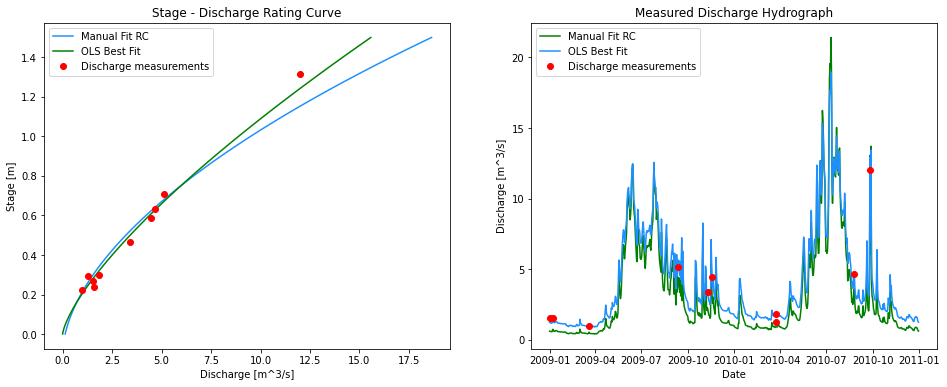

In [70]:
# here we specify 1, 2 for subplots meaning 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# left side plot - rating curve
ax[0].plot(manual_fit_q, stage_range, color='dodgerblue', label='Manual Fit RC')
ax[0].plot(bf_df['best_fit_q'], bf_df['stage'],
        color='green', label="OLS Best Fit")

ax[0].plot(rc_df[q_measured], rc_df[wl_measured], 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

# right side plot -- hydrograph
ax[1].plot(stage_df['Date'], stage_df['Manual Q (cms)'], color='green', label='Manual Fit RC')
ax[1].plot(stage_df['Date'], stage_df['RC Q (cms)'],
        color='dodgerblue', label="OLS Best Fit")

ax[1].plot(rc_df['Date'], rc_df[q_measured], 
           marker='o', color='r',
           linestyle='',
           label='Discharge measurements')

ax[0].set_title('Stage - Discharge Rating Curve')
ax[0].set_xlabel('Discharge [m^3/s]')
ax[0].set_ylabel('Stage [m]')
ax[0].legend()
# right side plot labels
ax[1].set_title('Measured Discharge Hydrograph')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Discharge [m^3/s]')
ax[1].legend()
plt.show()

## Summary and Reflection

In this notebook we have used discrete measurements to develop a relationship between water level and volumetric flow.  We've used this relationship to develop what is commonly called a 'measured flow series' (the plot above at right), but it's really just an estimate of a relationship that changes in time due to natural (geomorphological) processes.  As we saw in Notebook 1, there is uncertainty in the flow measurements themselves, as well as the water level.  In this notebook we see how these uncertainties translate to the stage-discharge relationship.

It is typical that the hydrometric station will record a greater range of water level than what is captured during site visits when discrete discharge measurements are taken.  This is because the hydrometric station is installed and left running to measure water level 'continuously' (at some frequency, 15 minutes is fairly common) for years at a time.  In many cases it isn't practical or cost effective to make more than three or four visits per year to the station to collect measurements, download stage data, check datalogger batteries, etc.  As a result, it is typical to have discrete discharge measurements over a narrower range of flow conditions than is measured by the hydrometric station, so our 'measured flow series' must then *extrapolate* from the range of conditions we have actually taken discrete measurements for.  

The 'measured flow series' is used in many applications in resource engineering.  Low flows are used to determine natural or baseline conditions for fish habitat impact assessments, high flows are used to size hydraulic structures, such as dam spillways.  Hydrometric stations are often installed in new locations to support projects that have multi-decade planning horizons.  

### Questions for Reflection

Ultimately, the rating curve translates measured water level into a discharge series to characterize a water resource and support decisions in policy and design.  In characterizing a water resource, not only is it common to extrapolate beyond the range of measured conditions, it is necessary to extrapolate into the future, introducing new and unique sources of uncertainty.

Briefly describe how your confidence in the flow predicted by the rating curve (the model) changes as a function of water level (low flow, median flow, high flow)?  Then describe your level of confidence in the rating curve accurately representing flow tomorrow, versus one year from now, versus ten years from now.  How might these concerns be addressed?  



The two plots below are linked.  Check the selection tools, and select points on one plot.  When validating data, it is helpful to be able to link the measurements on the rating curve plot and the daily flow series plot.  Consider how you would you check if the low flows were subject to a shift in the hydraulic control over time?    

## Additional Information

So far, we've created plots with the `matplotlib` plotting library.  There are many other plotting libraries to explore, such as [Seaborn](https://seaborn.pydata.org/), [Plotly](https://plotly.com/), [Bokeh](https://docs.bokeh.org/en/latest/) and related [Holoviews](https://holoviews.org/) and [Geoviews](https://geoviews.org/) for spatial data. 

Below we recreate the previous plot above and make it interactive.  Sometimes it is very powerful to zoom in on detailed data and have linked behaviour between plots.

In [71]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource, Band
from bokeh.io import output_notebook
from bokeh.layouts import gridplot

output_notebook()

Loading BokehJS ...

In [72]:
# customize the tools for interacting with the plot
TOOLS="pan,wheel_zoom,reset,hover,poly_select,box_select"

stage_df = stage_df.reset_index(drop=True)
# the Bokeh plotting library uses a "ColumnDataSource" data structure to 
# link plots and make them more interactive
# set data sources for plot linking
rc_source = ColumnDataSource(rc_df)
ts_source = ColumnDataSource(stage_df)

#### RATING CURVE PLOT (left side)
rc_plot = figure(plot_width=550, plot_height=400,
                title='Rating Curve Plot',
                tools=TOOLS)

# plot the measured discharge points as circle glyphs
rc_plot.circle('Flow (m3/s)', 'Water level (m)', size=5, color="red", alpha=0.5,
              legend_label='Measured Q', source=rc_source)

# plot the rating curve line based on the manual rating curve fit
rc_plot.line(manual_fit_q, stage_range, line_color='dodgerblue',
             legend_label='Manual Fit')

# plot the rating curve line based on the OLS best fit
rc_plot.line(bf_df['best_fit_q'], bf_df['stage'],
             line_color='green', legend_label='OLS Fit')

#### DAILY FLOW SERIES PLOT (right side)
# we can use the y_range attribute to link the plot scales
daily_flow_plot = figure(plot_width=550, plot_height=400, 
                        x_axis_type='datetime', 
                        title='Daily Flow Hydrograph',
                        y_range=rc_plot.x_range)

# # plot the flow series based on the OLS best fit
daily_flow_plot.line('Date', 'RC Q (cms)', 
                    legend_label='OLS-based RC Flow', color='green',
                    source=ts_source)

# plot the flow series based on the manual fit
daily_flow_plot.line('Date', 'Manual Q (cms)', 
                    legend_label='Manual RC Flow', color='dodgerblue',
                    source=ts_source)

# plot the daily flow series generated from the manual rating curve
daily_flow_plot.circle('Date', 'Flow (m3/s)', size=5, color="red", alpha=0.8,
              source=rc_source, legend_label='Measured Q')

# daily_flow_plot.line('Date', 'RC Q (cms)')
# label the axes
daily_flow_plot.xaxis.axis_label = 'Date'
daily_flow_plot.yaxis.axis_label = 'Flow (m³/s)'
daily_flow_plot.legend.location = "top_left"
rc_plot.xaxis.axis_label = 'Flow (m³/s)'
rc_plot.yaxis.axis_label = 'Stage (m)'
rc_plot.legend.location = "bottom_right"

layout = gridplot([[rc_plot, daily_flow_plot]])

# show the results
show(layout)